In [2]:
import numpy as np
import pandas as pd
import seaborn as sb
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
%matplotlib inline

/Users/more/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


# Data Preparation

In [3]:
df = pd.read_json('./data/train.json')
df["num_photos"] = df["photos"].apply(len)
df["num_features"] = df["features"].apply(len)
df["num_description_words"] = df["description"].apply(lambda x: len(x.split(" ")))
df["created"] = pd.to_datetime(df["created"])
df["created_year"] = df["created"].dt.year
df["created_month"] = df["created"].dt.month
df["created_day"] = df["created"].dt.day
df["linear_bias"] = 1
features_to_use = ["bathrooms", "bedrooms", "latitude", "longitude", "price",
                   "num_photos", "num_features", "num_description_words",
                   "created_year", "created_month", "created_day"]

In [4]:
# X = df.drop(['interest_level'], axis = 1)
X = df
y = df['interest_level']
X_tr, X_val, y_tr, y_val = train_test_split(X, y, test_size=0.33)
print X_tr.reset_index().loc[1,:]

index                                                                41014
bathrooms                                                                1
bedrooms                                                                 3
building_id                               fd878eb37e6db35649f76dc21d85e17d
created                                                2016-06-05 01:39:45
description              Charming 3 bedroom teeming with sunlight in th...
display_address                                              Second Avenue
features                 [Prewar, Elevator, Dishwasher, Cats Allowed, D...
interest_level                                                         low
latitude                                                           40.7298
listing_id                                                         7112065
longitude                                                         -73.9871
manager_id                                d4da529f5295859bb5c4ef8abbb0a38f
photos                   

# visualize

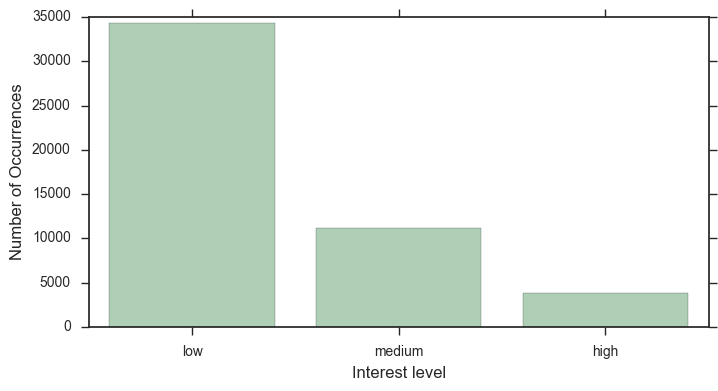

In [183]:
level_counts = df['interest_level'].value_counts()

plt.figure(figsize=(8,4))
sb.barplot(level_counts.index, level_counts.values, alpha=0.5, color=sb.color_palette()[1])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Interest level', fontsize=12)
plt.show()

(0, 300)

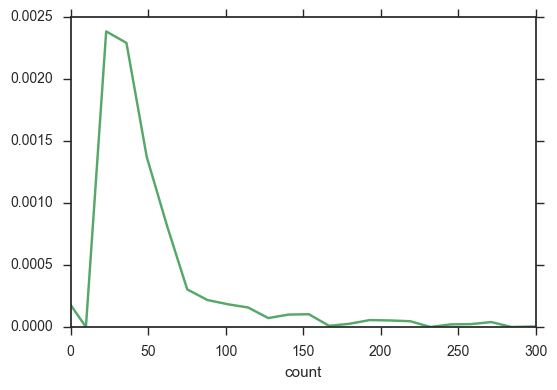

In [194]:
fig = plt.figure()
ax = fig.gca()
sb.distplot(temp['count'], hist=False, color=sb.color_palette()[1])
ax.set_xlim(0, 300)

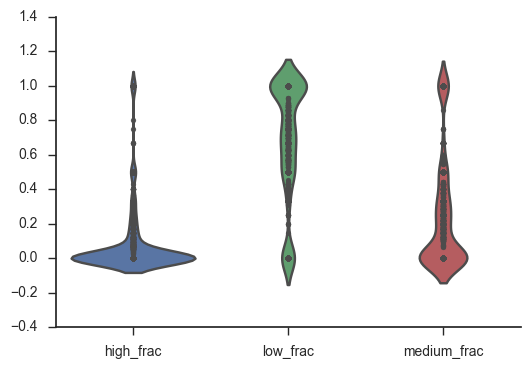

In [187]:
# plot
sb.set_style('ticks')
fig, ax = plt.subplots()
sb.violinplot(data=temp.loc[:, ['high_frac','low_frac', 'medium_frac']], inner="points", ax=ax)    
sb.despine()

# manage_id

In [6]:
from sklearn import preprocessing
# encoding the manage_id (from a hashcode to idx)
lbl = preprocessing.LabelEncoder()
lbl.fit(list(X_tr['manager_id'].values))
X_tr.loc[:, 'manager_id'] = lbl.transform(list(X_tr['manager_id'].values))
X_tr.loc[:, 'linear_bias'] = 1
temp = pd.concat([X_tr.manager_id, pd.get_dummies(y_tr)], axis = 1).groupby('manager_id').mean()
temp.columns = ['high_frac','low_frac', 'medium_frac']
temp['count'] = X_tr.groupby('manager_id').count().iloc[:,1]
temp['manager_skill'] = temp['high_frac']*2 + temp['medium_frac']

#             high_frac  low_frac  medium_frac  count  manager_skill
# manager_id                                                        
# 3093         0.000000  0.363636     0.636364     11       0.636364

In [7]:
low_count_managers_idx = temp['count'] < 20
assessed_managers_idx = ~low_count_managers_idx
mean_values = temp.loc[assessed_managers_idx, ['high_frac','low_frac', 'medium_frac','manager_skill']].mean()
temp.loc[low_count_managers_idx,['high_frac','low_frac', 'medium_frac','manager_skill']] = mean_values.values

# inner join to assign manager features to the managers in the training dataframe
X_tr = X_tr.merge(temp.reset_index(),how= 'left', left_on='manager_id', right_on='manager_id')

# add the features computed on the training dataset to the validation dataset
X_val = X_val.merge(temp.reset_index(), how='left', left_on='manager_id', right_on='manager_id')
new_manager_idx = X_val['high_frac'].isnull()
X_val.loc[new_manager_idx,['high_frac','low_frac', 'medium_frac','manager_skill']] = mean_values.values

features_to_use.extend(['manager_id', 'high_frac','low_frac', 'medium_frac','manager_skill'])

In [125]:
from sklearn.linear_model import LogisticRegression
feature_selected = ['manager_skill', 'linear_bias']
weight = level_counts / np.linalg.norm(level_counts)
weights = np.zeros(X_tr.shape[0])
for i, w in enumerate(weights):
    level = y_tr.values[i]
    if level == 'low':
        w = weight[0]
    elif level == 'medium':
        w = weight[1]
    else:
        w = weight[2]

clf = LogisticRegression(multi_class='multinomial', solver='lbfgs', verbose=1)
clf.fit(X_tr[feature_selected], y_tr, sample_weight=weights)
predict = clf.predict(X_val[feature_selected])

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished


# Some naive evaluation

In [44]:
temp = X_tr.loc[:, ['interest_level', 'manager_skill']]
mean_manager_skill = temp.groupby('interest_level').mean()
print mean_manager_skill
low_int = temp.loc[X_tr['interest_level'] == 'low'].manager_skill
medium_int = temp.loc[X_tr['interest_level'] == 'medium'].manager_skill
high_int = temp.loc[X_tr['interest_level'] == 'high'].manager_skill

                manager_skill
interest_level               
high                 0.611761
low                  0.341852
medium               0.510785


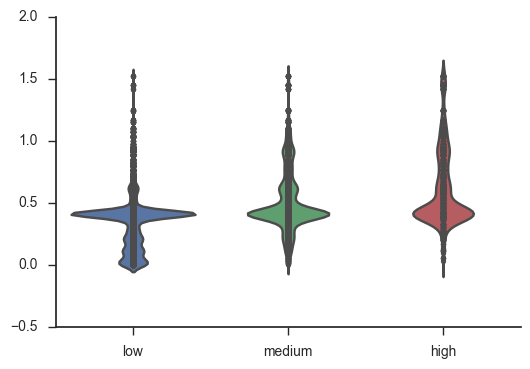

In [56]:
fig = plt.figure()
sb.set_style('ticks')
g = sb.violinplot(data=[low_int, medium_int, high_int], inner="points")    
g.set(xticklabels=['low','medium','high'])
sb.despine()